![MuJoCo banner](https://raw.githubusercontent.com/google-deepmind/mujoco/main/banner.png)

# <h1><center>Rollout Tutorial <a href="https://colab.research.google.com/github/google-deepmind/mujoco/blob/main/python/rollout.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" width="140" align="center"/></a></center></h1>

This notebook provides a tutorial for [**MuJoCo** physics](https://github.com/google-deepmind/mujoco#readme), using the native Python bindings.

This notebook describes a utility included in the MuJoCo Python library that performs simulation "rollouts" with an underlying C++ function. The rollouts can be multithreaded. We provide examples of the speed of rollout compared to pure Python rollouts and MJX and give an application example that couples "rollout" with MuJoCo's "minimize" utility.

<!-- Copyright 2025 DeepMind Technologies Limited

     Licensed under the Apache License, Version 2.0 (the "License");
     you may not use this file except in compliance with the License.
     You may obtain a copy of the License at

         http://www.apache.org/licenses/LICENSE-2.0

     Unless required by applicable law or agreed to in writing, software
     distributed under the License is distributed on an "AS IS" BASIS,
     WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
     See the License for the specific language governing permissions and
     limitations under the License.
-->

# All Imports

In [1]:
#@title All imports

!pip install mujoco
!pip install mujoco_mjx
!pip install brax

# Set up GPU rendering.
#from google.colab import files
import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# Check if installation was succesful.
try:
  print('Checking that the installation succeeded:')
  import mujoco
  from mujoco import minimize
  from mujoco import rollout
  from mujoco import mjx
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags

# Other imports and helper functions
import copy
import time
from multiprocessing import cpu_count
import itertools
import numpy as np
import jax
import jax.numpy as jp

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()

# Set the number of threads to the number of cpu cores available
nthread = cpu_count()

# Timing Functions

In [2]:
def benchmark(f, x_list=[None], ntiming=1):
  x_times_list = []
  for x in x_list:
    times = [time.perf_counter()]
    for i in range(ntiming):
      f(x)
      times.append(time.perf_counter())
    x_times_list.append(np.mean(np.diff(times)))
  return np.array(x_times_list)

# `rollout.rollout`

The `rollout.rollout` function in the `mujoco` Python library runs the simulation for a fixed number steps. It can run in single or multi-threaded modes. The speedup over pure Python is significant when using multithreading.

As a specific example let's consider the "tippe top" model (which is copied from the [tutorial notebook](https://colab.research.google.com/github/google-deepmind/mujoco/blob/main/python/tutorial.ipynb)). The "tippe top" is a spinning toy which flips itself ([video](https://www.youtube.com/watch?v=kbYpVrdcszQ), [Wikipedia](https://en.wikipedia.org/wiki/Tippe_top)). The simulation reproduces this behaviour:

In [3]:
#@title Tippe Top
tippe_top = """
<mujoco model="tippe top">
  <option integrator="RK4"/>

  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3"
     rgb2=".2 .3 .4" width="300" height="300"/>
    <material name="grid" texture="grid" texrepeat="40 40" reflectance=".2"/>
  </asset>

  <worldbody>
    <geom size="1 1 .01" type="plane" material="grid"/>
    <light pos="0 0 .6"/>
    <camera name="closeup" pos="0 -.1 .07" xyaxes="1 0 0 0 1 2"/>
    <camera name="distant" pos="0 -.3 .3" xyaxes="1 0 0 0 1 1"/>
    <body name="top" pos="0 0 .02">
      <freejoint name="top"/>
      <site name="top" pos="0 0 0"/>
      <geom name="ball" type="sphere" size=".02" />
      <geom name="stem" type="cylinder" pos="0 0 .02" size="0.004 .008"/>
      <geom name="ballast" type="box" size=".023 .023 0.005"  pos="0 0 -.015"
       contype="0" conaffinity="0" group="3"/>
    </body>
  </worldbody>

  <sensor>
    <gyro name="gyro" site="top"/>
  </sensor>

  <keyframe>
    <key name="spinning" qpos="0 0 0.02 1 0 0 0" qvel="0 0 0 0 1 200" />
  </keyframe>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(tippe_top)
data = mujoco.MjData(model)

# mujoco.mj_forward(model, data)
# with mujoco.Renderer(model) as renderer:
#   renderer.update_scene(data, camera="closeup")

#   media.show_image(renderer.render())
    
duration = 7    # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.
frames = []
mujoco.mj_resetDataKeyframe(model, data, 0)  # Reset the state to keyframe 0
with mujoco.Renderer(model) as renderer:
  while data.time < duration:
    mujoco.mj_step(model, data)
    if len(frames) < data.time * framerate:
      renderer.update_scene(data, "closeup")
      pixels = renderer.render()
      frames.append(pixels)

media.show_video(frames, fps=framerate)

## Pure Python versus `rollout.rollout`

Below we rollout the Tippe Top model in a Python loop and with `rollout.rollout` with a variety of batch sizes and number of simulation steps and plot their execution speeds.

The benchmark parameters are:

In [4]:
nominal_nstep = int(duration / model.opt.timestep) # Number of steps to use with the list of nbatch
nbatch = [1, 10, 100, 1000]

nominal_nbatch = 100 # Batch size to use with the list of nsteps
nstep = [1, 10, 100, 1000, int(duration / model.opt.timestep)]

ntiming = 1 # Number of times to rerun a benchmark for timing purposes

The code for a Python rollout with varying nbatch and nstep is:

In [5]:
def python_rollout(nbatch, nstep):
  for i in range(nbatch):
    mujoco.mj_resetDataKeyframe(model, data, 0)
    for i in range(nstep):
      mujoco.mj_step(model, data)

To do the same thing with `rollout.rollout`, we need to make an array of initial states to start the rollouts from. The method will execute the entire batch in a single call.

`rollout.rollout` can also parallelize the rollouts. To do so a list of MjData must be be passed, one per thread.

The resulting `rollout.rollout` function, parameterized by nbatch, nstep, and nthread is:

In [6]:
def native_rollout(nbatch, nstep, nthread):
  print('native_rollout', nbatch, nstep)
  # Get the initial condition that will be set to MjData before each rollout
  mujoco.mj_resetDataKeyframe(model, data, 0)
  initial_state = np.zeros((mujoco.mj_stateSize(model, mujoco.mjtState.mjSTATE_FULLPHYSICS),))
  mujoco.mj_getState(model, data, initial_state, mujoco.mjtState.mjSTATE_FULLPHYSICS)

  # Run the rollout
  rollout.rollout(model,
                  [copy.copy(data) for _ in range(nthread)], # Create one MjData per thread
                  np.tile(initial_state, (nbatch, 1)), # Tile the initial condition nbatch times
                  nstep=nstep)

Next, we benchmark the Python loop and `rollout.rollout` in both single threaded and multithreaded modes. This takes about 2 minutes on an Intel 12800HX.

In [7]:
#@title Python vs rollout.rollout benchmark
print('Benchmarking pure python')
t_python_nbatch = benchmark(lambda x: python_rollout(x,  nominal_nstep), nbatch, ntiming)
t_python_nstep  = benchmark(lambda x: python_rollout(nominal_nbatch, x), nstep,  ntiming)

print('Benchmarking single threaded rollout')
t_native_nbatch_single = benchmark(lambda x: native_rollout(x, nominal_nstep,  nthread=1), nbatch, ntiming)
t_native_nstep_single  = benchmark(lambda x: native_rollout(nominal_nbatch, x, nthread=1), nstep,  ntiming)

print('Benchmarking multi threaded rollout')
print(f'Using {nthread} threads')
t_native_nbatch = benchmark(lambda x: native_rollout(x, nominal_nstep,  nthread), nbatch, ntiming)
t_native_nstep  = benchmark(lambda x: native_rollout(nominal_nbatch, x, nthread), nstep,  ntiming)

print('Python rollout versus nbatch:                 {} seconds'.format(t_python_nbatch))
print('Native rollout single threaded versus nbatch: {} seconds'.format(t_native_nbatch_single))
print('Native rollout multi  threaded versus nbatch: {} seconds'.format(t_native_nbatch))

print('Python rollout versus nstep :                 {} seconds'.format(t_python_nstep))
print('Native rollout single threaded versus nstep : {} seconds'.format(t_native_nstep_single))
print('Native rollout multi  threaded versus nstep : {} seconds'.format(t_native_nstep))

Benchmarking pure python
Benchmarking single threaded rollout
native_rollout 1 3500
native_rollout 10 3500
native_rollout 100 3500
native_rollout 1000 3500
native_rollout 100 1
native_rollout 100 10
native_rollout 100 100
native_rollout 100 1000
native_rollout 100 3500
Benchmarking multi threaded rollout
Using 24 threads
native_rollout 1 3500
native_rollout 10 3500
native_rollout 100 3500
native_rollout 1000 3500
native_rollout 100 1
native_rollout 100 10
native_rollout 100 100
native_rollout 100 1000
native_rollout 100 3500
Python rollout versus nbatch:                 [ 0.042  0.415  4.088 40.898] seconds
Native rollout single threaded versus nbatch: [ 0.055  0.393  3.919 39.155] seconds
Native rollout multi  threaded versus nbatch: [0.052 0.071 0.363 3.63 ] seconds
Python rollout versus nstep :                 [0.001 0.012 0.123 1.261 4.083] seconds
Native rollout single threaded versus nstep : [0.002 0.012 0.119 1.216 3.926] seconds
Native rollout multi  threaded versus nstep : [0.

Multithreaded rollouts are much faster! Let's also plot the speed of each method:

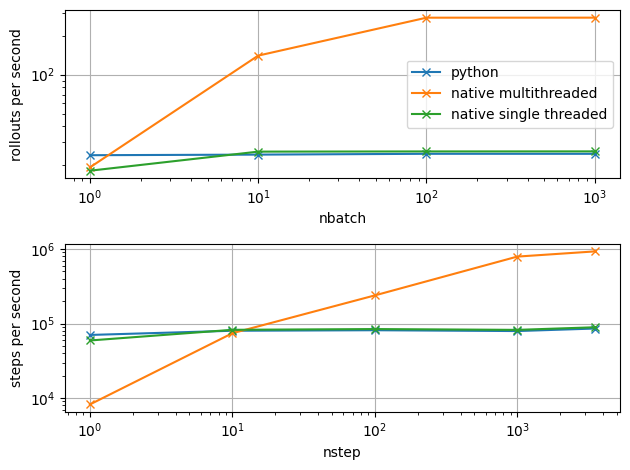

In [8]:
#@title Plot Results
plt.subplot(2,1,1)
plt.loglog(nbatch, nbatch / t_python_nbatch, marker='x', label='python')
plt.loglog(nbatch, nbatch / t_native_nbatch, marker='x', label='native multithreaded')
plt.loglog(nbatch, nbatch / t_native_nbatch_single, marker='x', label='native single threaded')
plt.grid()
plt.xlabel('nbatch')
plt.ylabel('rollouts per second')
plt.legend()

plt.subplot(2,1,2)
steps_per_t = np.array(nstep) * nominal_nbatch
plt.loglog(nstep, steps_per_t / t_python_nstep, marker='x', label='python')
plt.loglog(nstep, steps_per_t / t_native_nstep, marker='x', label='native multithreaded')
plt.loglog(nstep, steps_per_t / t_native_nstep_single, marker='x', label='native single threaded')
plt.grid()
plt.xlabel('nstep')
plt.ylabel('steps per second')
plt.tight_layout()

So, `rollout.rollout` is a little faster than Python rollouts when single threaded, and in this case, as much as 10x faster when multithreaded.

## MJX versus `rollout.rollout`

Let's compare `rollout.rollout` with MJX using same benchmark as above, with the maximum batch speed increased by 10x. The benchmark below takes 5 minutes on an Intel 12800HX and A2000 8GB GPU.

**Note:** MJX is most useful when coupled with something else that runs best on a GPU, like a neural network. Without any such additional workload, CPU based simulation will often be faster, especially when using less than state-of-the-art GPUs.

In [9]:
# Increase the maximum batch size
nbatch_mjx = [1, 10, 100, 1000, 10000, 100000]
nominal_nstep_mjx = nominal_nstep // 5

# Reset the MjData
mujoco.mj_resetData(model, data)
mujoco.mj_resetDataKeyframe(model, data, 0)  # Reset the state to keyframe 0

# Make MJX versions of model and data
mjx_model = mjx.put_model(model)
mjx_data = mjx.put_data(model, data)

jit_step = jax.jit(jax.vmap(mjx.step, in_axes=(None, 0)))
def mjx_rollout(nbatch, nstep):
  print('mjx_rollout', nbatch, nstep)
  batch = jax.vmap(lambda x: mjx_data)(jp.array(list(range(nbatch))))
  print('done mapping')
  for _ in range(nstep):
    batch = jit_step(mjx_model, batch)

t_mjx_nbatch = benchmark(lambda x: mjx_rollout(x,  nominal_nstep_mjx), nbatch_mjx, ntiming)
t_mjx_nstep  = benchmark(lambda x: mjx_rollout(nominal_nbatch, x), nstep,  ntiming)

# Rerun multithreaded native rollout with the increased batch size
# t_native_nbatch = benchmark(lambda x: native_rollout(x, nominal_nstep,  nthread), nbatch, ntiming)

print('MJX rollout versus nbatch:    {} seconds'.format(t_mjx_nbatch))
#print('Native rollout versus nbatch: {} seconds'.format(t_native_nbatch, nbatch / t_native_nbatch))
print('MJX rollout versus nstep : {} seconds'.format(t_mjx_nstep))

mjx_rollout 1 700
done mapping
mjx_rollout 10 700
done mapping
mjx_rollout 100 700
done mapping
mjx_rollout 1000 700
done mapping
mjx_rollout 10000 700
done mapping
mjx_rollout 100000 700
done mapping
mjx_rollout 100 1
done mapping
mjx_rollout 100 10
done mapping
mjx_rollout 100 100
done mapping
mjx_rollout 100 1000
done mapping
mjx_rollout 100 3500
done mapping
MJX rollout versus nbatch:    [ 16.897  18.824  19.205  19.075  34.821 345.3  ] seconds
MJX rollout versus nstep : [ 0.014  0.053  0.435  4.625 15.379] seconds


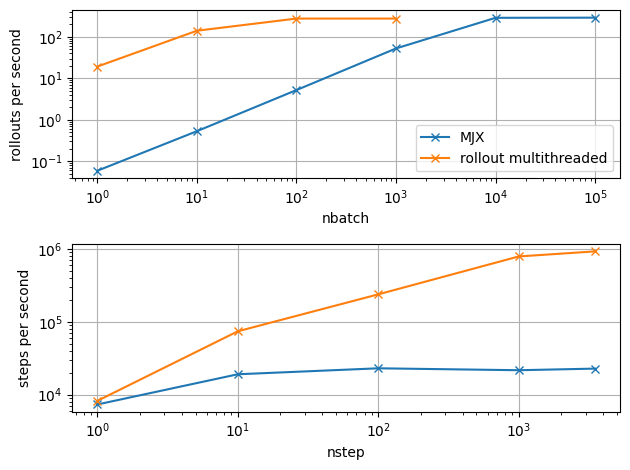

ValueError: operands could not be broadcast together with shapes (6,) (4,) 

In [10]:
#@title Plot Results
plt.subplot(2,1,1)
plt.loglog(nbatch_mjx, nbatch_mjx / t_mjx_nbatch, marker='x', label='MJX')
plt.loglog(nbatch, nbatch / t_native_nbatch, marker='x', label='rollout multithreaded')
plt.grid()
plt.xlabel('nbatch')
plt.ylabel('rollouts per second')
plt.legend()

plt.subplot(2,1,2)
steps_per_t = np.array(nstep) * nominal_nbatch
plt.loglog(nstep, steps_per_t / t_mjx_nstep, marker='x', label='MJX')
plt.loglog(nstep, steps_per_t / t_native_nstep, marker='x', label='rollout multithreaded')
plt.grid()
plt.xlabel('nstep')
plt.ylabel('steps per second')
plt.tight_layout()
plt.show()

print('t_mjx_nbatch / t_native_nbatch', t_mjx_nbatch / t_native_nbatch)

In this case, `rollout.rollout` is still 2.6x faster even with a very large batch of 10,000 rollouts. With batch sizes of 10-100, `rollout.rollout` can be a few orders of magnitude faster.

## Usage Examples

Hopefully, the benchmarks above convinced you to use `rollout.rollout`. Next, we look at `rollout.rollout`'s docstring and give an examples of the most common use cases.

**Note:** The more advanced arguments are discussed in the "Advanced Usage" section below.

In [ ]:
print(rollout.rollout.__doc__)

### Example: different initial states
`rollout.rollout` is designed to run nbatch rollouts in parallel for nstep steps. Lets simulate 100 tippe tops with different initial rotation speeds.

In [ ]:
#@title rendering helper function
def render_many(model, data, state, framerate, camera=-1, shift_joint=None, ncols=10, spacing=(1., 1.)):
  nbatch = state.shape[0]

  if not isinstance(model, mujoco.MjModel):
    model = list(model)
    
  if isinstance(model, list) and len(model) == 1:
    model = model * nbatch
  elif isinstance(model, list):
    assert len(model) == nbatch
  else:
    model = [model] * nbatch

  # Visual options
  vopt = mujoco.MjvOption()
  vopt.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = True  # Transparent.
  pert = mujoco.MjvPerturb()  # Empty MjvPerturb object
  catmask = mujoco.mjtCatBit.mjCAT_DYNAMIC
    
  # Simulate and render.
  frames = []
  with mujoco.Renderer(model[0], 480, 640) as renderer:
    for i in range(state.shape[1]):
      if len(frames) < i * model[0].opt.timestep * framerate:
        for j in range(state.shape[0]):
          mujoco.mj_setState(model[j], data, state[j, i, :], mujoco.mjtState.mjSTATE_FULLPHYSICS)
          mujoco.mj_forward(model[j], data)

          if shift_joint is not None:
            grid_x = j % ncols
            grid_y = j // ncols
            #print(grid_x, grid_y)
            data.joint(shift_joint).qpos[:3] = data.joint(shift_joint).qpos[:3] + (grid_x * spacing[0], grid_y * spacing[1], 0)
            mujoco.mj_forward(model[j], data)

          # Add the first top to the scene
          if j == 0:
            renderer.update_scene(data, camera, scene_option=vopt)
          else:
            mujoco.mjv_addGeoms(model[j], data, vopt, pert, catmask, renderer.scene)
        # Render and add the frame.
        pixels = renderer.render()
        frames.append(pixels)
  return frames

In [ ]:
nbatch = 100 # Simulate this many tops

# Get the initial condition that will be set to MjData before each rollout
mujoco.mj_resetDataKeyframe(model, data, 0)
initial_state = np.zeros((mujoco.mj_stateSize(model, mujoco.mjtState.mjSTATE_FULLPHYSICS),))
mujoco.mj_getState(model, data, initial_state, mujoco.mjtState.mjSTATE_FULLPHYSICS)
initial_states = np.tile(initial_state, (nbatch, 1))

# Scale the initial speed of the tippe top
initial_states[:, -1] *= np.linspace(0.5, 1.5, num=nbatch)

# Run the rollout
state, sensordata = rollout.rollout(model, [copy.copy(data) for _ in range(nthread)], # Create one MjData per thread
                                    initial_states, nstep=nominal_nstep)

# Use state to render all the tops at once
framerate = 60
media.show_video(render_many(model, data, state, framerate), fps=framerate)

Our model has one angular velocity in the middle of the top. Let's plot that as well.

In [ ]:
plt.subplot(3,1,1)
for i in range(nbatch): plt.plot(sensordata[i, :, 0])
plt.subplot(3,1,2)
for i in range(nbatch): plt.plot(sensordata[i, :, 1])
plt.subplot(3,1,3)
for i in range(nbatch): plt.plot(sensordata[i, :, 2])

### Example: different models
100 gray tops is kind of boring. It would be better if they were colorful and different sizes!

Thankfully, rollout supports using different models for each rollout, so long as they are of compatibile dimensions. Let's simulate 100 tippe tops with the same initial condition, but different sizes and colors.

**Note:** Strictly speaking, the models must have the same number of states, controls, degrees of freedom, and sensor outputs. The most common use case is multiple models of the same thing up to parameter values.

In [ ]:
# Make 100 tippe tops with different colors and sizes
nbatch = 100
spec = mujoco.MjSpec.from_string(tippe_top)
models = []
for i in range(nbatch):
  for geom in spec.geoms:
    if geom.name in ['ball', 'stem', 'ballast']:
      geom.rgba[:3] = np.random.rand(3)
    if geom.name == 'stem':
      stem_geom = geom
    if geom.name == 'ball':
      ball_geom = geom

  # Save original geom size
  stem_geom_size = np.copy(stem_geom.size)
  ball_geom_size = np.copy(ball_geom.size)

  # Scale geoms and compile model
  size_scale = np.random.rand(1) + 0.1
  stem_geom.size *= size_scale
  ball_geom.size *= size_scale
  models.append(spec.compile())

  # Restore original geom size
  stem_geom.size = stem_geom_size
  ball_geom.size = ball_geom_size

# Run the rollout
state, sensordata = rollout.rollout(models, [copy.copy(data) for _ in range(nthread)], # Create one MjData per thread
                                    initial_state, nstep=nominal_nstep)
# Render video
framerate = 120
cam = mujoco.MjvCamera()
mujoco.mjv_defaultCamera(cam)
cam.distance = 0.2
cam.azimuth = 135
cam.elevation = -25
cam.lookat = [0, 0, 0.07]
models[0].vis.global_.fovy = 60
frames = render_many(models, data, state, framerate, shift_joint='top', spacing=[-0.05, 0.05], camera=cam)
media.show_video(frames, fps=framerate) # Show the video at half speed

Because the models are now different, the measurements of the gyro sensor are not consistent even though the initial state for each rollout was the same.

In [ ]:
plt.subplot(3,1,1)
for i in range(nbatch): plt.plot(sensordata[i, :, 0])
plt.subplot(3,1,2)
for i in range(nbatch): plt.plot(sensordata[i, :, 1])
plt.subplot(3,1,3)
for i in range(nbatch): plt.plot(sensordata[i, :, 2])

### Example: control inputs
Open loop control inputs can be passed to `rollout.rollout` via the `control` argument. If passed, `nstep` no longer needs to be specified as it can be inferred from the size of `control`.

Below we simulate 100 of the flailing humanoids from the [tutorial notebook](https://colab.research.google.com/github/google-deepmind/mujoco/blob/main/python/tutorial.ipynb). Each humanoid uses a different control signal.

In [ ]:
# Get MuJoCo's standard humanoid model.
print('Getting MuJoCo humanoid XML description from GitHub:')
#!git clone https://github.com/google-deepmind/mujoco
with open('../model/humanoid/humanoid.xml', 'r') as f:
  humanoid_xml = f.read()

# Load the model, make two MjData's.
#del model
model = mujoco.MjModel.from_xml_string(humanoid_xml)
data = mujoco.MjData(model)

# Episode parameters.
duration = 3       # (seconds)
framerate = 120     # (Hz)
#data.qpos[0:2] = [-.5, -.5]  # Initial x-y position (m)
data.qvel[2] = 4   # Initial vertical velocity (m/s)
ctrl_phase = 2 * np.pi * np.random.rand(model.nu)  # Control phase
ctrl_freq = 1     # Control frequency

# Generate 100 different controls
nbatch = 100
nstep = int(duration / model.opt.timestep)
times = np.linspace(0.0, duration, nstep)
times = np.arange(0.0, duration, model.opt.timestep)
control = np.sin((2 * np.pi * times * ctrl_freq).reshape(nstep, 1) + ctrl_phase.reshape(1, model.nu))
control = np.stack([control]*nbatch, axis=0)
control += np.random.normal(size=control.shape)

initial_state = np.zeros((mujoco.mj_stateSize(model, mujoco.mjtState.mjSTATE_FULLPHYSICS),))
mujoco.mj_getState(model, data, initial_state, mujoco.mjtState.mjSTATE_FULLPHYSICS)
state, _ = rollout.rollout(model, [copy.copy(data) for _ in range(nthread)], initial_state, control)

cam = mujoco.MjvCamera()
mujoco.mjv_defaultCamera(cam)
cam.distance = 3.5
cam.azimuth = 135
cam.elevation = -35
cam.lookat = [0, 0, 3.0]
model.vis.global_.fovy = 60
frames = render_many(model, data, state, framerate, shift_joint='root', spacing=[-1.0, 1.0], camera=cam)
media.show_video(frames, fps=framerate/2) # Show the video at half speed

`rollout.rollout`'s `control_spec` argument can be used to indicate `control` contains values for actuators, generalized forces, cartesian forces, mocap poses, and/or the activation/deactivation of equality constraints. Internally, this is managed through [mj_setState](https://mujoco.readthedocs.io/en/stable/APIreference/APIfunctions.html#mj-setstate) and `control_spec` corresponds to `mj_setState`'s `spec` argument.

Let's try applying cartesian forces in addition to the control inputs. This will make the humanoids look like they are being dragged while waving their limbs.

In [ ]:
xfrc = np.zeros((control.shape[0], control.shape[1], mujoco.mj_stateSize(model, mujoco.mjtState.mjSTATE_XFRC_APPLIED)))
head_id = model.body('head').id
xfrc[:, :, 3*head_id:3*head_id+2] =  np.random.normal(scale=100.0, size=(control.shape[0], 1, 2)) # Apply a constant but different force to each model

control_xfrc = np.concatenate((control, xfrc), axis=2)
control_spec = mujoco.mjtState.mjSTATE_CTRL.value + mujoco.mjtState.mjSTATE_XFRC_APPLIED.value
state, _ = rollout.rollout(model, [copy.copy(data) for _ in range(nthread)], initial_state, control_xfrc, control_spec=control_spec)

frames = render_many(model, data, state, framerate, shift_joint='root', spacing=[-1.0, 1.0], camera=cam)
media.show_video(frames, fps=framerate/2) # Show the video at half speed

# Application: `rollout.rollout` + `minimize.least_squares`

`rollout.rollout` can be easily used with MuJoCo's nonlinear least squares utility, `minimize.least_squares`. Because `minimize` uses finite-differencing to estimate jacobians, it benefits greatly from multi-threaded rollouts.

As an example let's consider the "reach" sample from the [least squares notebook](https://colab.research.google.com/github/google-deepmind/mujoco/blob/main/python/least_squares.ipynb). The code is copied here with a small modification that allows multithreading.

The goal is for the humanoid to reach a target with one of its hands. By default, the humanoid does a jump, but does not reach its hand to the target.

In [7]:
#@title Humanoid Reaching XML and code
xml = """
<mujoco model="Humanoid">
  <option timestep="0.005"/>

  <visual>
    <map force="0.1" zfar="30"/>
    <rgba haze="0.15 0.25 0.35 1"/>
    <global offwidth="2560" offheight="1440" elevation="-20" azimuth="120"/>
  </visual>

  <statistic center="0 0 0.7"/>

  <asset>
    <texture type="skybox" builtin="gradient" rgb1=".3 .5 .7" rgb2="0 0 0" width="32" height="512"/>
    <texture name="body" type="cube" builtin="flat" mark="cross" width="128" height="128" rgb1="0.8 0.6 0.4" rgb2="0.8 0.6 0.4" markrgb="1 1 1" random="0.01"/>
    <material name="body" texture="body" texuniform="true" rgba="0.8 0.6 .4 1"/>
    <texture name="grid" type="2d" builtin="checker" width="512" height="512" rgb1=".1 .2 .3" rgb2=".2 .3 .4"/>
    <material name="grid" texture="grid" texrepeat="1 1" texuniform="true" reflectance=".2"/>
  </asset>

  <default>
    <position inheritrange="0.95"/>
    <default class="body">

      <!-- geoms -->
      <geom type="capsule" condim="1" friction=".7" solimp="0.9 .99 .003" solref=".015 1" material="body" group="1"/>
      <default class="thigh">
        <geom size=".06"/>
      </default>
      <default class="shin">
        <geom fromto="0 0 0 0 0 -.3"  size=".049"/>
      </default>
      <default class="foot">
        <geom size=".027"/>
        <default class="foot1">
          <geom fromto="-.07 -.01 0 .14 -.03 0"/>
        </default>
        <default class="foot2">
          <geom fromto="-.07 .01 0 .14  .03 0"/>
        </default>
      </default>
      <default class="arm_upper">
        <geom size=".04"/>
      </default>
      <default class="arm_lower">
        <geom size=".031"/>
      </default>
      <default class="hand">
        <geom type="sphere" size=".04"/>
      </default>

      <!-- joints -->
      <joint type="hinge" damping=".2" stiffness="1" armature=".01" limited="true" solimplimit="0 .99 .01"/>
      <default class="joint_big">
        <joint damping="5" stiffness="10"/>
        <default class="hip_x">
          <joint range="-30 10"/>
        </default>
        <default class="hip_z">
          <joint range="-60 35"/>
        </default>
        <default class="hip_y">
          <joint axis="0 1 0" range="-150 20"/>
        </default>
        <default class="joint_big_stiff">
          <joint stiffness="20"/>
        </default>
      </default>
      <default class="knee">
        <joint pos="0 0 .02" axis="0 -1 0" range="-160 2"/>
      </default>
      <default class="ankle">
        <joint range="-50 50"/>
        <default class="ankle_y">
          <joint pos="0 0 .08" axis="0 1 0" stiffness="6"/>
        </default>
        <default class="ankle_x">
          <joint pos="0 0 .04" stiffness="3"/>
        </default>
      </default>
      <default class="shoulder">
        <joint range="-85 60"/>
      </default>
      <default class="elbow">
        <joint range="-100 50" stiffness="0"/>
      </default>
    </default>
  </default>

  <worldbody>
    <body name="target" pos=".2 -.2 1" mocap="true">
      <site name="target" size=".05" rgba="1 0 1 .4"/>
    </body>
    <geom name="floor" size="0 0 .05" type="plane" material="grid" condim="3"/>
    <light name="spotlight" mode="targetbodycom" target="torso" diffuse=".8 .8 .8" specular="0.3 0.3 0.3" pos="0 -6 4" cutoff="30"/>
    <body name="torso" pos="0 0 1.282" childclass="body">
      <light name="top" pos="0 0 2" mode="trackcom"/>
      <camera name="back" pos="-3 0 1" xyaxes="0 -1 0 1 0 2" mode="trackcom"/>
      <camera name="side" pos="0 -3 1" xyaxes="1 0 0 0 1 2" mode="trackcom"/>
      <freejoint name="root"/>
      <geom name="torso" fromto="0 -.07 0 0 .07 0" size=".07"/>
      <geom name="waist_upper" fromto="-.01 -.06 -.12 -.01 .06 -.12" size=".06"/>
      <body name="head" pos="0 0 .19">
        <geom name="head" type="sphere" size=".09"/>
        <camera name="egocentric" pos=".09 0 0" xyaxes="0 -1 0 .1 0 1" fovy="80"/>
      </body>
      <body name="waist_lower" pos="-.01 0 -.26">
        <geom name="waist_lower" fromto="0 -.06 0 0 .06 0" size=".06"/>
        <joint name="abdomen_z" pos="0 0 .065" axis="0 0 1" range="-45 45" class="joint_big_stiff"/>
        <joint name="abdomen_y" pos="0 0 .065" axis="0 1 0" range="-75 30" class="joint_big"/>
        <body name="pelvis" pos="0 0 -.165">
          <joint name="abdomen_x" pos="0 0 .1" axis="1 0 0" range="-35 35" class="joint_big"/>
          <geom name="butt" fromto="-.02 -.07 0 -.02 .07 0" size=".09"/>
          <body name="thigh_right" pos="0 -.1 -.04">
            <joint name="hip_x_right" axis="1 0 0" class="hip_x"/>
            <joint name="hip_z_right" axis="0 0 1" class="hip_z"/>
            <joint name="hip_y_right" class="hip_y"/>
            <geom name="thigh_right" fromto="0 0 0 0 .01 -.34" class="thigh"/>
            <body name="shin_right" pos="0 .01 -.4">
              <joint name="knee_right" class="knee"/>
              <geom name="shin_right" class="shin"/>
              <body name="foot_right" pos="0 0 -.39">
                <joint name="ankle_y_right" class="ankle_y"/>
                <joint name="ankle_x_right" class="ankle_x" axis="1 0 .5"/>
                <geom name="foot1_right" class="foot1"/>
                <geom name="foot2_right" class="foot2"/>
              </body>
            </body>
          </body>
          <body name="thigh_left" pos="0 .1 -.04">
            <joint name="hip_x_left" axis="-1 0 0" class="hip_x"/>
            <joint name="hip_z_left" axis="0 0 -1" class="hip_z"/>
            <joint name="hip_y_left" class="hip_y"/>
            <geom name="thigh_left" fromto="0 0 0 0 -.01 -.34" class="thigh"/>
            <body name="shin_left" pos="0 -.01 -.4">
              <joint name="knee_left" class="knee"/>
              <geom name="shin_left" fromto="0 0 0 0 0 -.3" class="shin"/>
              <body name="foot_left" pos="0 0 -.39">
                <joint name="ankle_y_left" class="ankle_y"/>
                <joint name="ankle_x_left" class="ankle_x" axis="-1 0 -.5"/>
                <geom name="foot1_left" class="foot1"/>
                <geom name="foot2_left" class="foot2"/>
              </body>
            </body>
          </body>
        </body>
      </body>
      <body name="upper_arm_right" pos="0 -.17 .06">
        <joint name="shoulder1_right" axis="2 1 1"  class="shoulder"/>
        <joint name="shoulder2_right" axis="0 -1 1" class="shoulder"/>
        <geom name="upper_arm_right" fromto="0 0 0 .16 -.16 -.16" class="arm_upper"/>
        <body name="lower_arm_right" pos=".18 -.18 -.18">
          <joint name="elbow_right" axis="0 -1 1" class="elbow"/>
          <geom name="lower_arm_right" fromto=".01 .01 .01 .17 .17 .17" class="arm_lower"/>
          <body name="hand_right" pos=".18 .18 .18">
            <geom name="hand_right" zaxis="1 1 1" class="hand" rgba="1 0 1 1"/>
          </body>
        </body>
      </body>
      <body name="upper_arm_left" pos="0 .17 .06">
        <joint name="shoulder1_left" axis="-2 1 -1" class="shoulder"/>
        <joint name="shoulder2_left" axis="0 -1 -1"  class="shoulder"/>
        <geom name="upper_arm_left" fromto="0 0 0 .16 .16 -.16" class="arm_upper"/>
        <body name="lower_arm_left" pos=".18 .18 -.18">
          <joint name="elbow_left" axis="0 -1 -1" class="elbow"/>
          <geom name="lower_arm_left" fromto=".01 -.01 .01 .17 -.17 .17" class="arm_lower"/>
          <body name="hand_left" pos=".18 -.18 .18">
            <geom name="hand_left" zaxis="1 -1 1" class="hand"/>
          </body>
        </body>
      </body>
    </body>
  </worldbody>

  <contact>
    <exclude body1="waist_lower" body2="thigh_right"/>
    <exclude body1="waist_lower" body2="thigh_left"/>
  </contact>

  <tendon>
    <fixed name="hamstring_right" limited="true" range="-0.3 2">
      <joint joint="hip_y_right" coef=".5"/>
      <joint joint="knee_right" coef="-.5"/>
    </fixed>
    <fixed name="hamstring_left" limited="true" range="-0.3 2">
      <joint joint="hip_y_left" coef=".5"/>
      <joint joint="knee_left" coef="-.5"/>
    </fixed>
  </tendon>

  <actuator>
    <position name="abdomen_z"       kp="40"  joint="abdomen_z"/>
    <position name="abdomen_y"       kp="40"  joint="abdomen_y"/>
    <position name="abdomen_x"       kp="40"  joint="abdomen_x"/>
    <position name="hip_x_right"     kp="40"  joint="hip_x_right"/>
    <position name="hip_z_right"     kp="40"  joint="hip_z_right"/>
    <position name="hip_y_right"     kp="120" joint="hip_y_right"/>
    <position name="knee_right"      kp="80"  joint="knee_right"/>
    <position name="ankle_y_right"   kp="20"  joint="ankle_y_right"/>
    <position name="ankle_x_right"   kp="20"  joint="ankle_x_right"/>
    <position name="hip_x_left"      kp="40"  joint="hip_x_left"/>
    <position name="hip_z_left"      kp="40"  joint="hip_z_left"/>
    <position name="hip_y_left"      kp="120" joint="hip_y_left"/>
    <position name="knee_left"       kp="80"  joint="knee_left"/>
    <position name="ankle_y_left"    kp="20"  joint="ankle_y_left"/>
    <position name="ankle_x_left"    kp="20"  joint="ankle_x_left"/>
    <position name="shoulder1_right" kp="20"  joint="shoulder1_right"/>
    <position name="shoulder2_right" kp="20"  joint="shoulder2_right"/>
    <position name="elbow_right"     kp="40"  joint="elbow_right"/>
    <position name="shoulder1_left"  kp="20"  joint="shoulder1_left"/>
    <position name="shoulder2_left"  kp="20"  joint="shoulder2_left"/>
    <position name="elbow_left"      kp="40"  joint="elbow_left"/>
  </actuator>

  <sensor>
    <framepos objtype="geom" objname="hand_right" reftype="xbody" refname="target"/>
    <actuatorfrc actuator="abdomen_z"/>
    <actuatorfrc actuator="abdomen_y"/>
    <actuatorfrc actuator="abdomen_x"/>
    <actuatorfrc actuator="hip_x_right"/>
    <actuatorfrc actuator="hip_z_right"/>
    <actuatorfrc actuator="hip_y_right"/>
    <actuatorfrc actuator="knee_right"/>
    <actuatorfrc actuator="ankle_y_right"/>
    <actuatorfrc actuator="ankle_x_right"/>
    <actuatorfrc actuator="hip_x_left"/>
    <actuatorfrc actuator="hip_z_left"/>
    <actuatorfrc actuator="hip_y_left"/>
    <actuatorfrc actuator="knee_left"/>
    <actuatorfrc actuator="ankle_y_left"/>
    <actuatorfrc actuator="ankle_x_left"/>
    <actuatorfrc actuator="shoulder1_right"/>
    <actuatorfrc actuator="shoulder2_right"/>
    <actuatorfrc actuator="elbow_right"/>
    <actuatorfrc actuator="shoulder1_left"/>
    <actuatorfrc actuator="shoulder2_left"/>
    <actuatorfrc actuator="elbow_left"/>
  </sensor>

  <keyframe>
    <!--
    The values below are split into rows for readibility:
      torso position
      torso orientation
      spinal
      right leg
      left leg
      arms
    -->
    <key name="squat"
         qpos="0 0 0.596
               0.988015 0 0.154359 0
               0 0.4 0
               -0.25 -0.5 -2.5 -2.65 -0.8 0.56
               -0.25 -0.5 -2.5 -2.65 -0.8 0.56
               0 0 0 0 0 0"/>
    <key name="stand_on_left_leg"
         qpos="0 0 1.21948
               0.971588 -0.179973 0.135318 -0.0729076
               -0.0516 -0.202 0.23
               -0.24 -0.007 -0.34 -1.76 -0.466 -0.0415
               -0.08 -0.01 -0.37 -0.685 -0.35 -0.09
               0.109 -0.067 -0.7 -0.05 0.12 0.16"/>
    <key name="prone"
         qpos="0.4 0 0.0757706
               0.7325 0 0.680767 0
               0 0.0729 0
               0.0077 0.0019 -0.026 -0.351 -0.27 0
               0.0077 0.0019 -0.026 -0.351 -0.27 0
               0.56 -0.62 -1.752
               0.56 -0.62 -1.752"/>
    <key name="supine"
         qpos="-0.4 0 0.08122
               0.722788 0 -0.69107 0
               0 -0.25 0
               0.0182 0.0142 0.3 0.042 -0.44 -0.02
               0.0182 0.0142 0.3 0.042 -0.44 -0.02
               0.186 -0.73 -1.73
               0.186 -0.73 -1.73"/>
  </keyframe>
</mujoco>
"""

# Load model, make data, make list of data for multithreading
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
data_list = [mujoco.MjData(model) for _ in range(nthread)]

# Set the state to the "squat" keyframe, call mj_forward.
key = model.key('squat').id
mujoco.mj_resetDataKeyframe(model, data, key)
mujoco.mj_forward(model, data)

# If a renderer exists, close it.
if 'renderer' in locals():
  renderer.close()

# Make a Renderer and a camera.
renderer = mujoco.Renderer(model)
camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 3
camera.elevation = -10

# Point the camera at the humanoid, render.
# camera.lookat = data.body('torso').subtree_com
# renderer.update_scene(data, camera)
# media.show_image(renderer.render())

def reach(ctrl0T, target, T, torque_scale, traj=None, multithread=False):
  """Residual for target-reaching task.

  Args:
    ctrl0T: contatenation of the first and last control vectors.
    target: target to which the right hand should reach.
    T: final time for the rollout.
    torque_scale: coefficient by which to scale the torques.
    traj: optional list of positions to be recorded.

  Returns:
    The residual of the target-reaching task.
  """
  # Extract the initial and final ctrl vectors, transpose to row vectors
  ctrl0 = ctrl0T[:model.nu, :].T
  ctrlT = ctrl0T[model.nu:, :].T

  # Move the mocap body to the target
  mocapid = model.body('target').mocapid
  data.mocap_pos[mocapid] = target

  # Append the mocap targets to the controls
  nroll  = ctrl0.shape[0]
  mocap = np.tile(data.mocap_pos[mocapid], (nroll, 1))
  ctrl0 = np.hstack((ctrl0, mocap))
  ctrlT = np.hstack((ctrlT, mocap))

  # Define control spec (ctrl + mocap_pos)
  mjtState = mujoco.mjtState
  control_spec = mjtState.mjSTATE_CTRL | mjtState.mjSTATE_MOCAP_POS

  # Interpolate and stack the control sequences
  nstep = int(np.round(T / model.opt.timestep))
  control = np.stack(np.linspace(ctrl0, ctrlT, nstep), axis=1)

  if not multithread:
    datas = [data]
  else:
    datas = data_list
    
  # Reset to the "squat" keyframe, get the initial state
  for d in datas:
    key = model.key('squat').id
    mujoco.mj_resetDataKeyframe(model, d, key)
    spec = mjtState.mjSTATE_FULLPHYSICS
    nstate = mujoco.mj_stateSize(model, spec)
    state = np.empty(nstate)
    mujoco.mj_getState(model, d, state, spec)

  # Perform rollouts (sensors.shape == nroll, nstep, nsensordata)
  states, sensors = rollout.rollout(model, datas, state, control,
                                    control_spec=control_spec)

  # If requested, extract qpos into traj
  if traj is not None:
    assert states.shape[0] == 1
    # Skip the first element in state (mjData.time)
    traj.extend(np.split(states[0, :, 1:model.nq+1], nstep))

  # Scale torque sensors
  sensors[:, :, 3:] *= torque_scale

  # Reshape to stack the sensor values, transpose to column vectors
  sensors = sensors.reshape((sensors.shape[0], -1)).T

  # The normalizer keeps objective values similar when changing T or timestep.
  normalizer = 100 * model.opt.timestep / T
  return normalizer * sensors

def render_solution(x, target):
  # Ask reach to save positions to traj.
  traj = []
  reach(x, target, T, torque_scale, traj=traj);

  frames = []
  counter = 0
  print('Rendering frames:', flush=True, end='')
  for qpos in traj:
    # Set positions, call mj_forward to update kinematics.
    data.qpos = qpos
    mujoco.mj_forward(model, data)

    # Render and save frames.
    camera.lookat = data.body('torso').subtree_com
    renderer.update_scene(data, camera)
    pixels = renderer.render()
    frames.append(pixels)
    counter += 1
    if counter % 10 == 0:
      print(f' {counter}', flush=True, end='')
  return frames

# Settings for the optimization
T = 0.7               # Rollout length (seconds)
torque_scale = 0.003  # Scaling for the torques

# Bounds are the stacked control bounds.
lower = np.atleast_2d(model.actuator_ctrlrange[:,0]).T
upper = np.atleast_2d(model.actuator_ctrlrange[:,1]).T
bounds = [np.vstack((lower, lower)), np.vstack((upper, upper))]

# Initial guess is midpoint of the bounds
x0 = 0.5 * (bounds[1] + bounds[0])
target = (.4, -.3, 1.2)

# Use default target.
target = data.mocap_pos[model.body('target').mocapid]

# Visualize the initial guess.
media.show_video(render_solution(x0, target))

Rendering frames: 10 20 30 40 50 60 70 80 90 100 110 120 130 140

Next, let's run the optimization in a single threaded and multi-threaded modes and render the resulting solutions.

In [8]:
reach_target = lambda x: reach(x, target, T, torque_scale, traj=None, multithread=False)
reach_target_multithread = lambda x: reach(x, target, T, torque_scale, traj=None, multithread=True)

print('Using 1 thread')
x_single, _ = minimize.least_squares(x0, reach_target, bounds, verbose=minimize.Verbosity.FINAL)
print()

print(f'Using {nthread} threads')
x_multi, _ = minimize.least_squares(x0, reach_target_multithread, bounds, verbose=minimize.Verbosity.FINAL)

# Render the solution to verify the results are the same
print()
frames_single = render_solution(x_single, target)
frames_multi = render_solution(x_multi, target)
media.show_video(np.concatenate((frames_single, frames_multi), axis=2))

Using 1 thread
Terminated after 15 iterations: insufficient reduction. y: 1.91, Residual evals: 831
total time 3.0s of which residual 99.5%

Using 24 threads
Terminated after 15 iterations: insufficient reduction. y: 1.91, Residual evals: 831
total time 1.3s of which residual 98.7%

Rendering frames: 10 20 30 40 50 60 70 80 90 100 110 120 130 140Rendering frames: 10 20 30 40 50 60 70 80 90 100 110 120 130 140

By the using multithreaded `rollout.rollout` the minimization completed 2.5x faster and the results are the same.

# Advanced Usage
## skip_checks=True

By default rollout performs many checks on the dimensions of its arguments. This it allows it to infer dimensions such as `nroll` and `nstep`, tile arguments that were not fully specified, and allocate the returned `state` and `sensordata` arrays.

However, these check take time, particularly if `state` and `sensordata` are large or if there are many models and `nstep` is low. So advanced users may want to use the `skip_checks=True` argument in order to acheive additional performance.

If used, certain arguments become non-optional, and all signals must be fully defined (no implicit tiling). In particular:
* `model` must be a list of length `nroll`
* `data` must be a list of length `nthread`
* `nstep` must be specified
* `initial_state` must be an array of shape `nroll x nstate`
* `control` is optional, but if passed must be an array of shape `nroll x nstep x ncontrol`
* `state` is optional, but must be passed if state is to be returned, must be of shape `nroll x nstep x nstate`
* `sensordata` is optional, but must be passed if sensor data is to be returned, must be of shape `nroll x nstep x nsensordata`

As an extreme example, we pass 10,000 humanoid models to `rollout.rollout` and simulate 1 step each with and without checks.

In [29]:
nbatch = 10000
nstep = 1
ntiming = 100

datas = [copy.copy(data) for _ in range(nthread)]
initial_state = np.zeros((mujoco.mj_stateSize(model, mujoco.mjtState.mjSTATE_FULLPHYSICS),))
mujoco.mj_getState(model, data, initial_state, mujoco.mjtState.mjSTATE_FULLPHYSICS)
initial_state_tiled = np.tile(initial_state, (nbatch, 1))

def rollout_with_checks():
    state, _ = rollout.rollout([model]*nbatch, datas, initial_state, nstep=nstep)

def rollout_skip_checks():
    rollout.rollout([model]*nbatch, datas, initial_state_tiled, nstep=nstep, skip_checks=True)

t_with_checks = benchmark(lambda _: rollout_with_checks(), ntiming=ntiming)
t_skip_checks = benchmark(lambda _: rollout_skip_checks(), ntiming=ntiming)

print(f'with checks {t_with_checks} seconds')
print(f'skip checks {t_skip_checks} seconds')

with checks [0.031] seconds
skip checks [0.023] seconds


In this case skip checks is about 25% faster.

Notice that the version with checks can use the non-tiled `initial_state`, however the skip checks version must used the tiled version, `initial_state_tiled`.

## chunk_size

## warmstart

Below we provide a simple example with the chaotic pendulum demo from the [tutorial notebook](https://colab.research.google.com/github/google-deepmind/mujoco/blob/main/python/tutorial.ipynb).

In [15]:
#!@title chaotic pendulum

chaotic_pendulum = """
<mujoco>
  <option timestep=".001">
    <flag energy="enable" contact="disable"/>
  </option>

  <default>
    <joint type="hinge" axis="0 -1 0"/>
    <geom type="capsule" size=".02"/>
  </default>

  <worldbody>
    <light pos="0 -.4 1"/>
    <camera name="fixed" pos="0 -1 0" xyaxes="1 0 0 0 0 1"/>
    <body name="0" pos="0 0 .2">
      <joint name="root"/>
      <geom fromto="-.2 0 0 .2 0 0" rgba="1 1 0 1"/>
      <geom fromto="0 0 0 0 0 -.25" rgba="1 1 0 1"/>
      <body name="1" pos="-.2 0 0">
        <joint/>
        <geom fromto="0 0 0 0 0 -.2" rgba="1 0 0 1"/>
      </body>
      <body name="2" pos=".2 0 0">
        <joint/>
        <geom fromto="0 0 0 0 0 -.2" rgba="0 1 0 1"/>
      </body>
      <body name="3" pos="0 0 -.25">
        <joint/>
        <geom fromto="0 0 0 0 0 -.2" rgba="0 0 1 1"/>
      </body>
    </body>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(chaotic_pendulum)
data = mujoco.MjData(model)

# setup
n_seconds = 6
framerate = 30  # Hz
n_frames = int(n_seconds * framerate)
frames = []
height = 240
width = 320

# set initial state
mujoco.mj_resetData(model, data)
data.joint('root').qvel = 10

# simulate and record frames
frame = 0
sim_time = 0
render_time = 0
n_steps = 0
with mujoco.Renderer(model, height, width) as renderer:
  for i in range(n_frames):
    while data.time * framerate < i:
      tic = time.time()
      mujoco.mj_step(model, data)
      sim_time += time.time() - tic
      n_steps += 1
    tic = time.time()
    renderer.update_scene(data, "fixed")
    frame = renderer.render()
    render_time += time.time() - tic
    frames.append(frame)

# print timing and play video
step_time = 1e6*sim_time/n_steps
step_fps = n_steps/sim_time
print(f'simulation: {step_time:5.3g} μs/step  ({step_fps:5.0f}Hz)')
frame_time = 1e6*render_time/n_frames
frame_fps = n_frames/render_time
print(f'rendering:  {frame_time:5.3g} μs/frame ({frame_fps:5.0f}Hz)')
print('\n')

# show video
media.show_video(frames, fps=framerate)

simulation:     2 μs/step  (500598Hz)
rendering:    255 μs/frame ( 3928Hz)




## Reusing threadpools with `rollout.Rollout`

The `rollout` module provided the class `rollout.Rollout` in addition to the method `rollout.rollout`. The class `rollout.Rollout` is designed allow safe reuse of the internally managed thread pool.

Reuse can speed things up considerably when rollouts are short. Let's find out how the speedup changes for the tippe top model by rolling it out with increasing numbers of steps.

In [ ]:
model = mujoco.MjModel.from_xml_string(tippe_top)
data = mujoco.MjData(model)
nbatch = 100

mujoco.mj_resetDataKeyframe(model, data, 0)
initial_state = np.zeros((mujoco.mj_stateSize(model, mujoco.mjtState.mjSTATE_FULLPHYSICS),))
mujoco.mj_getState(model, data, initial_state, mujoco.mjtState.mjSTATE_FULLPHYSICS)
initial_states = np.tile(initial_state, (nbatch, 1))

datas = [copy.copy(data) for _ in range(nthread)]

def rollout_method(nstep):
  for i in range(10):
    rollout.rollout(model, datas, initial_states, nstep=nstep)

def rollout_class(nstep):
  with rollout.Rollout(nthread=nthread) as rollout_:
    for i in range(10):
      rollout_.rollout(model, datas, initial_states, nstep=nstep)

nsteps = [2**i for i in [2, 3, 4, 5, 6, 7]]
ntiming = 30
t_method = benchmark(lambda x: rollout_method(x), nsteps, ntiming)
t_class = benchmark(lambda x: rollout_class(x), nsteps, ntiming)

print(t_method)
print(t_class)

We can see there is a significant speedup when nstep is low. Let's plot the ratio.

In [ ]:
plt.plot(nsteps, t_method / t_class, marker='x', label='method')
plt.xlabel('nstep')
plt.ylabel('speedup (t_method/t_class)')
plt.grid()

So, for low nstep, (about 4 to 32 steps) we can get a 2x to 1.2x speedup by reusing the threadpool.

See the "Advanced Usage" section for how to use persistent threadpools with the method `rollout.rollout`.

## Reusing threadpools with `rollout.rollout`

## How not to reuse threadpools